<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelization with the CNN network fed with the images

Here we explore the approach of the convolutional neural network that is fed with the images we have extracted from the wikipedia pages of the entities. It is not the most classical and intuitive approach to the entity classification problem, but maybe we could somehow benefit from this approach

In [ ]:
'''data import'''
from google.colab import files
uploaded = files.upload()


import pandas as pd
from PIL import Image
from torchvision import transforms
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

In [ ]:
uploaded = files.upload()

Saving dev_df_images.json to dev_df_images.json


In [ ]:
train_df_images = pd.read_json('train_df_images.json', orient="records", lines=True)
dev_df_images = pd.read_json('dev_df_images.json', orient="records", lines=True)

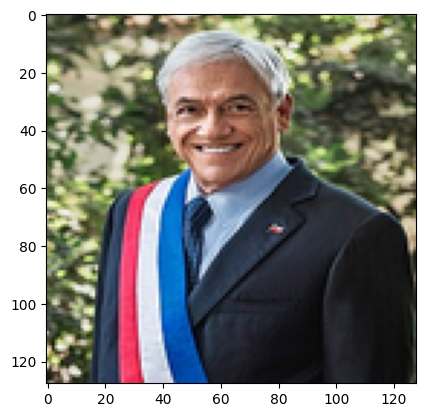

In [ ]:
''''sanity check of the images'''
img = train_df_images['image'][0]
plt.imshow(img)

In [ ]:
train_df_images.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,"[[[89, 90, 72], [95, 98, 79], [76, 81, 60], [6..."
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,"[[[33, 31, 16], [34, 32, 17], [37, 35, 19], [3..."
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,"[[[111, 112, 104], [111, 112, 104], [113, 114,..."
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,"[[[126, 82, 35], [128, 82, 33], [130, 83, 32],..."
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,"[[[106, 88, 76], [106, 88, 76], [108, 90, 78],..."


In [ ]:
train_df_images['label'].unique()

array(['cultural exclusive', 'cultural representative',
       'cultural agnostic', 'cultural', 'cult', None, 'cultural agn',
       'cultural represent', 'cultural ex', 'cultural ag'], dtype=object)

In [ ]:
print(type(train_df_images.loc[1,'image']))

<class 'numpy.ndarray'>


In [ ]:
dev_df_images.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,null
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,"[[[65, 128, 58], [62, 125, 55], [67, 126, 58],..."
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,"[[[107, 144, 153], [106, 143, 152], [104, 140,..."
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,"[[51, 44, 41, 41, 41, 35, 82, 59, 29, 53, 82, ..."


Mapping labels to integers

In [ ]:
# Clean the labels (see notebook cleaning data for more details)

# Select the labels and associated labels to correct
to_correct = train_df_images[train_df_images["label"].isin(['cultural agn','cultural represent', 'cultural ex', 'cultural ag'])][['item', 'label']]

# Create the mapping for correction
mapping_correction = {
  'cultural agn' : 'cultural agnostic',
  'cultural represent' : 'cultural representative',
  'cultural ex' : 'cultural exclusive',
  'cultural ag' : 'cultural agnostic'
}

# Apply the correction
to_correct['label'] = to_correct['label'].map(mapping_correction)

# We update the transformations to the initial dataset
train_df_images.set_index('item', inplace=True)
to_correct.set_index('item', inplace=True)

train_df_images.update(to_correct)
train_df_images.reset_index(inplace=True)

In [ ]:
# Select the items that have no label, or with label 'cultural', or 'cult'
to_classify = train_df_images[(train_df_images["label"].isin(["cultural", "cult"])) | (train_df_images["label"].isna())][['item', 'name', 'description']]

# Create the dictionnary for the mapping
categories = {
    'http://www.wikidata.org/entity/Q957033': 'cultural representative',
    'http://www.wikidata.org/entity/Q30327019': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q811361': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q12014207': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q257907': 'cultural exclusive',
    'http://www.wikidata.org/entity/Q1136336': 'cultural representative',
    'http://www.wikidata.org/entity/Q67111': 'cultural representative',
    'http://www.wikidata.org/entity/Q1089672': 'cultural representative',
    'http://www.wikidata.org/entity/Q85755629': 'cultural representative',
    'http://www.wikidata.org/entity/Q206912': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q23228': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q3196604': 'cultural representative',
    'http://www.wikidata.org/entity/Q1940624': 'cultural representative'
}

# Apply the classification
to_classify['label'] = to_classify['item'].map(categories)

# We update the transformations to the initial dataset
train_df_images.set_index('item', inplace=True)
to_classify.set_index('item', inplace=True)

train_df_images.update(to_classify)
train_df_images.reset_index(inplace=True)

In [ ]:
labels = train_df_images['label'].unique()
dict_mapping ={}

for i, label in enumerate(labels):
  dict_mapping[label]=int(i)
  i = i+1

print(dict_mapping)

for df in [train_df_images, dev_df_images]:
  df['label'] = df['label'].map(dict_mapping)
  df['label'] = df['label'].apply(lambda x: np.array(x))

{'cultural exclusive': 0, 'cultural representative': 1, 'cultural agnostic': 2}


In [ ]:
train_df_images.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,0,"[[[89, 90, 72], [95, 98, 79], [76, 81, 60], [6..."
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,1,"[[[33, 31, 16], [34, 32, 17], [37, 35, 19], [3..."
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,1,"[[[111, 112, 104], [111, 112, 104], [113, 114,..."
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,1,"[[[126, 82, 35], [128, 82, 33], [130, 83, 32],..."
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,1,"[[[106, 88, 76], [106, 88, 76], [108, 90, 78],..."


## Fill in or drop

In case of the images  we have a lot of missing values, since some of the images on the wikipedia pages are protected against scraping and we couldnt retrieve them and some pages do not include images. We have two possible way we could deal with this issue, we could either drop the entities without image and not include them during the training, or just fill thier image variable with NAN


In [ ]:
def fill_NaN_image(image):

  """
  If a cell is empty, it fills in with a white image, of dimension (128,128,3) ie (height, width, channels)
  """

  if image is None or (isinstance(image, float) and np.isnan(image)):
    image = np.ones((128, 128, 3), dtype=np.uint8) * 255

  return image



In [ ]:
def clean_images(df, fill=True, drop=False):

  if fill == True:
    df['image'] = df['image'].apply(lambda x: fill_NaN_image(x))

  if drop == True:
    df = df[df['image'].notna()]

  return df

In [ ]:
# Create a dataframe where we only keep the item that have an image
train_df_images_without_na = clean_images(train_df_images, fill=False, drop=True)
dev_df_images_without_na = clean_images(dev_df_images, fill=False, drop=True)


# Create a dataframe where we keep all the image, and fill in the NaN with white images
train_df_images_fill = clean_images(train_df_images, fill=True, drop=False)
dev_df_images_fill = clean_images(dev_df_images, fill=True, drop=False)

# The model the pretrained vvg will be tried on
Since we do not have much image data and also not much computational power/time we will use the pretrained on the imagenet vgg16 model setting the base model layers to non-trainable and only adding some final layers to fine-tune the model to our task

In [ ]:
def build_a_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

In [ ]:
train_df_images_without_na.head()

,item,name,description,type,category,subcategory,label,image
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,0,"[[[89, 90, 72], [95, 98, 79], [76, 81, 60], [6..."
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,1,"[[[33, 31, 16], [34, 32, 17], [37, 35, 19], [3..."
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,1,"[[[111, 112, 104], [111, 112, 104], [113, 114,..."
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,1,"[[[126, 82, 35], [128, 82, 33], [130, 83, 32],..."
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,1,"[[[106, 88, 76], [106, 88, 76], [108, 90, 78],..."


### Dataset class defninition
we had to resort to usage of the dataset from generator, since we could not proceed with the usuall pd.dataframes as the ram was not able to hold all the arrays and would always crush during the session

In [ ]:


def image_generator(df):
  # the standard generator template
  for idx, row in df.iterrows():
    image = np.array(row['image'])
    label = row['label']
    yield image, label

model_without_na = build_a_model(input_shape=(224, 224, 3), num_classes=3)

#the dataset from generator syntax
train_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(train_df_images_without_na),
    output_types=(tf.uint8, tf.int64),
    #ensuring proper output shape to avoid shape mismatch issues
    output_shapes=((128, 128, 3), ()))
# the dataset from generator syntax
dev_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(dev_df_images_without_na),
    output_types=(tf.uint8, tf.int64),
    #ensuring proper output shape to avoid shape mismatch issues
    output_shapes=((128, 128, 3), ()))

# The prefatch to ensure the computational efficency important since image data is heavy
# smaller batch ensure enough ram
train_dataset = train_dataset.map(preprocess).cache().shuffle(1024).batch(8).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.map(preprocess).cache().shuffle(1024).batch(8).prefetch(tf.data.AUTOTUNE)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model_without_na.fit(train_dataset, epochs=40, validation_data=dev_dataset, callbacks=[early_stopping])
train_loss, train_accuracy = model_without_na.evaluate(train_dataset)
dev_loss, dev_accuracy = model_without_na.evaluate(dev_dataset)
print(f"Accuracy on the train set : {train_accuracy:.4f}")
print(f"Accuracy on the dev set : {dev_accuracy:.4f}")

Epoch 1/40
    277/Unknown 1217s 4s/step - accuracy: 0.4841 - loss: 1.9662

we interrupted the training after the first epoch  as it was very slow and did not seem any promising ,

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


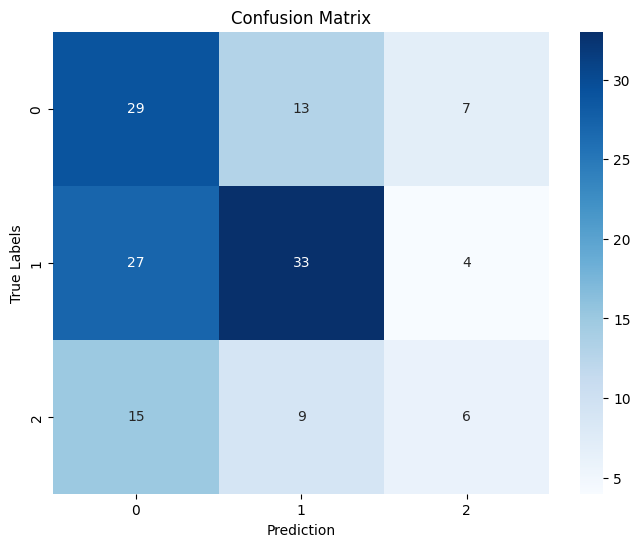

In [ ]:
y_pred = model_without_na.predict(X_dev_without_na)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_dev_without_na, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# 2. Compute Precision, Recall, and F1-score (in mean macro)
precision = precision_score(y_dev_without_na, y_pred_classes, average='macro')
recall = recall_score(y_dev_without_na, y_pred_classes, average='macro')
f1 = f1_score(y_dev_without_na, y_pred_classes, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# 3. More complete informations
print("\n")
print(classification_report(y_dev_without_na, y_pred_classes))

Precision : 0.4538
Recall : 0.4358
F1 Score : 0.4311


              precision    recall  f1-score   support

           0       0.41      0.59      0.48        49
           1       0.60      0.52      0.55        64
           2       0.35      0.20      0.26        30

    accuracy                           0.48       143
   macro avg       0.45      0.44      0.43       143
weighted avg       0.48      0.48      0.47       143

